# Learning Order Relations

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-colorblind')

import itertools

2023-04-16 00:44:10.835741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 00:44:10.981043: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-16 00:44:11.020893: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-16 00:44:11.789827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Order Relation Model


**Task**: Given two objects $(o_1, o_2) \in \mathcal{O} \times \mathcal{O}$, predict the relation $o_1 \prec o_2$

**Model**: 
1) Embed each object: $o_1 \mapsto e_1, o_2 \mapsto e_2$
2) Project the first object via $W^1$ and the second object via $W^2$, then compute inner product: $\langle W^1 e_1, W^2 e_2 \rangle$.
3) Return relation as sigmoid function $\text{Sigmoid}\left( \langle W^1 e_1, W^2 e_2 \rangle \right)$

*Note:* Here, the objects are tokens. (i.e.: integers. so the embedding layer maps $i \mapsto e_i$ for each $i \in \{1, ..., |\mathcal{O}| \}$)

In [2]:
class OrderRelation(tf.keras.Model):
    def __init__(self, num_objects, embedding_dim, proj_dim, name=None):
        super().__init__(name=name)
        self.num_objects = num_objects
        self.embedding_dim = embedding_dim
        self.proj_dim = proj_dim
    
    def build(self, input_shape):

        self.embedding = layers.Embedding(input_dim=self.num_objects, output_dim=self.embedding_dim)

        normal_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=.1, seed=1)
        self.W1 = tf.Variable(normal_initializer(shape=(self.embedding_dim, self.proj_dim)), trainable=True)
        self.W2 = tf.Variable(normal_initializer(shape=(self.embedding_dim, self.proj_dim)), trainable=True)
    
    def compute_innerprod_rel(self, inputs):
        embeddings = self.embedding(inputs)
        
        o1 = embeddings[:, 0]
        o2 = embeddings[:, 1]
        e1 = tf.matmul(o1, self.W1)
        e2 = tf.matmul(o2, self.W2)

        innerprod_rel = tf.einsum('ij,ij->i', e1, e2) # compute inner product

        return innerprod_rel

    def call(self, inputs):

        innerprod_rel = self.compute_innerprod_rel(inputs)

        return innerprod_rel

## Order Relation Dataset

Model is fit on all pairs of objects and their associated relations.

In [3]:
# create data set for learning order relatios
num_objects = 64
object_pairs = np.array(list(itertools.permutations(range(num_objects), r=2)))
object_order_relations = (object_pairs[:,0] < object_pairs[:, 1]).astype(int)

In [4]:
sample = np.random.choice(len(object_pairs), 10)
for object_pair, relation in zip(object_pairs[sample], object_order_relations[sample]):
    print(f'object pair: {tuple(object_pair)}; relation: {relation}')

object pair: (4, 6); relation: 1
object pair: (28, 26); relation: 0
object pair: (24, 55); relation: 1
object pair: (55, 15); relation: 0
object pair: (21, 40); relation: 1
object pair: (30, 55); relation: 1
object pair: (1, 42); relation: 1
object pair: (45, 39); relation: 0
object pair: (5, 17); relation: 1
object pair: (60, 37); relation: 0


## Fit Relation Model

In [5]:
embedding_dim = 16
proj_dim = 8

order_relation = OrderRelation(num_objects, embedding_dim, proj_dim, name='order_relation')
order_relation(object_pairs); # build model
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
order_relation.compile(loss='mse', optimizer=opt, metrics='binary_accuracy')

2023-04-16 00:44:13.988759: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-16 00:44:13.988806: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: p08r06n36.grace.hpc.yale.internal
2023-04-16 00:44:13.988818: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: p08r06n36.grace.hpc.yale.internal
2023-04-16 00:44:13.988910: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.61.5
2023-04-16 00:44:13.988948: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.61.5
2023-04-16 00:44:13.988956: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 520.61.5
2023-04-16 00:44:13.989725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library 

In [6]:
order_relation.fit(object_pairs, object_order_relations, epochs=200, batch_size=len(object_pairs))

Epoch 1/200
1/1 [==============================] - 0s 410ms/step - loss: 0.5000 - binary_accuracy: 0.5000
Epoch 2/200
1/1 [==============================] - 0s 6ms/step - loss: 0.4935 - binary_accuracy: 0.5000
Epoch 3/200
1/1 [==============================] - 0s 7ms/step - loss: 0.4329 - binary_accuracy: 0.5000
Epoch 4/200
1/1 [==============================] - 0s 5ms/step - loss: 0.2772 - binary_accuracy: 0.5000
Epoch 5/200
1/1 [==============================] - 0s 6ms/step - loss: 0.4763 - binary_accuracy: 0.5000
Epoch 6/200
1/1 [==============================] - 0s 6ms/step - loss: 0.2049 - binary_accuracy: 0.6595
Epoch 7/200
1/1 [==============================] - 0s 6ms/step - loss: 0.2109 - binary_accuracy: 0.5913
Epoch 8/200
1/1 [==============================] - 0s 6ms/step - loss: 0.2473 - binary_accuracy: 0.5067
Epoch 9/200
1/1 [==============================] - 0s 6ms/step - loss: 0.2541 - binary_accuracy: 0.6687
Epoch 10/200
1/1 [==============================] - 0s 6ms/ste

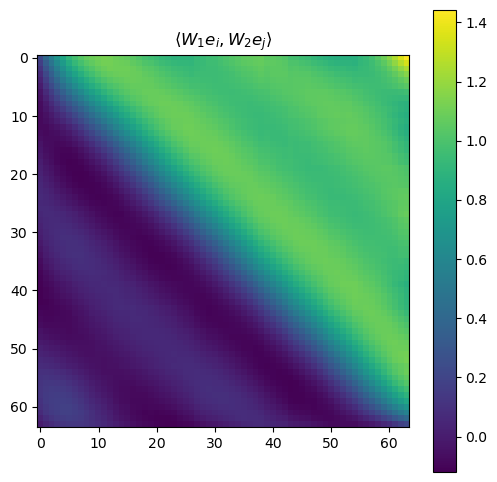

In [7]:
order_relation_matrix = np.zeros(shape=(num_objects, num_objects))

for i in range(num_objects):
    for j in range(num_objects):
        order_relation_matrix[i,j] = order_relation.compute_innerprod_rel(np.array([[i,j]]))[0].numpy()

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(order_relation_matrix)
fig.colorbar(im, ax=ax);
ax.set_title('$\\langle W_1 e_i, W_2 e_j \\rangle$');

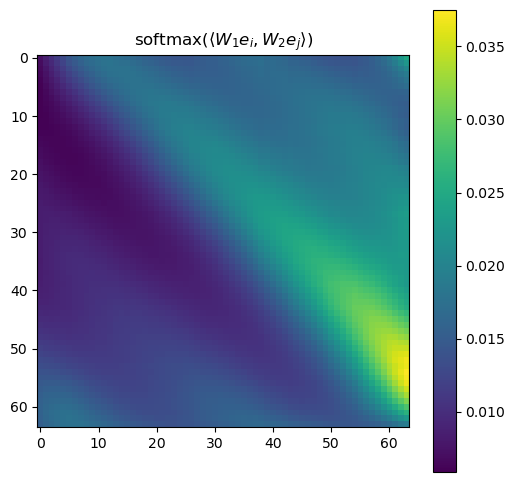

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(tf.nn.softmax(order_relation_matrix, axis=1))
fig.colorbar(im, ax=ax);
ax.set_title('$\\mathrm{softmax}(\\langle W_1 e_i, W_2 e_j \\rangle)$');

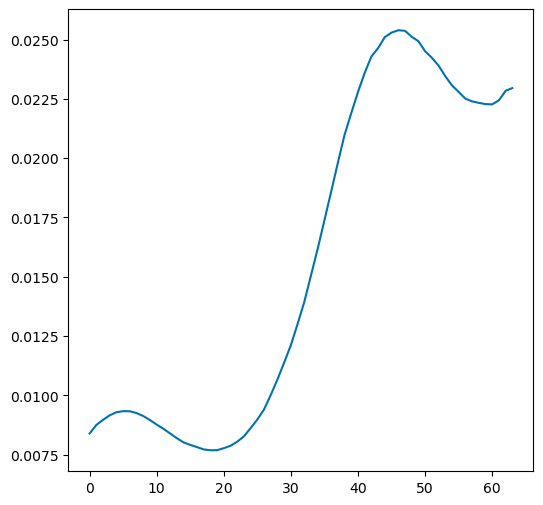

In [9]:
x = tf.nn.softmax(order_relation_matrix, axis=1)
# x = order_relation_matrix
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x[32, :])

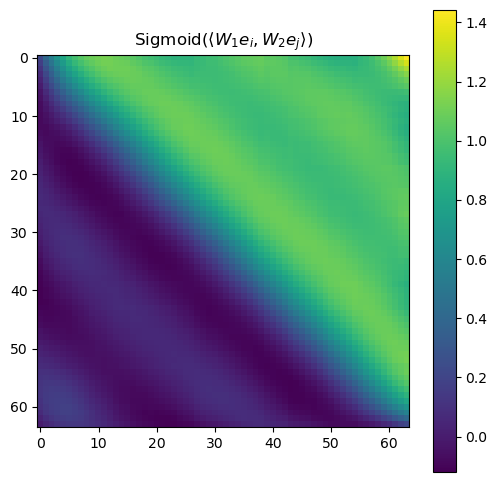

In [10]:
order_relation_matrix = np.zeros(shape=(num_objects, num_objects))

for i in range(num_objects):
    for j in range(num_objects):
        order_relation_matrix[i,j] = order_relation(np.array([[i,j]]))[0].numpy()

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(order_relation_matrix)
fig.colorbar(im, ax=ax);
ax.set_title('$\\mathrm{Sigmoid}(\\langle W_1 e_i, W_2 e_j \\rangle)$');

# Learn Order Relation with `SimpleAbstractor`

In [11]:
import sys; sys.path.append('..'); sys.path.append('../..')

from abstracters import SimpleAbstractor

In [32]:
class AbstractorOrderRelation(tf.keras.Model):
    def __init__(self, name=None):
        super().__init__(name=name)
    
    def build(self, input_shape):
        # note: changed activation of MHA to tanh!
        self.abstractor = SimpleAbstractor(num_layers=1, num_heads=1, dff=32, use_pos_embedding=False, mha_activation_type='tanh')
        self.dense = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.abstractor(inputs)
        x = x[:, 0]
        x = self.dense(x)

        return x 

In [33]:
object_pairs_onehot = tf.one_hot(object_pairs, num_objects)

In [34]:
model = AbstractorOrderRelation()
model(object_pairs_onehot)
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics='binary_accuracy')
model.summary()

Model: "abstractor_order_relation_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 relational_abstracter (Simp  multiple                 21216     
 leAbstractor)                                                   
                                                                 
 dense_6 (Dense)             multiple                  65        
                                                                 
Total params: 21,281
Trainable params: 21,281
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(object_pairs_onehot, object_order_relations, epochs=500, batch_size=len(object_pairs))

Epoch 1/500
1/1 [==============================] - 1s 792ms/step - loss: 0.7875 - binary_accuracy: 0.5022
Epoch 2/500
1/1 [==============================] - 0s 25ms/step - loss: 4.5635 - binary_accuracy: 0.5000
Epoch 3/500
1/1 [==============================] - 0s 26ms/step - loss: 2.1720 - binary_accuracy: 0.5000
Epoch 4/500
1/1 [==============================] - 0s 27ms/step - loss: 0.7211 - binary_accuracy: 0.4955
Epoch 5/500
1/1 [==============================] - 0s 24ms/step - loss: 1.1870 - binary_accuracy: 0.5000
Epoch 6/500
1/1 [==============================] - 0s 23ms/step - loss: 0.7623 - binary_accuracy: 0.5159
Epoch 7/500
1/1 [==============================] - 0s 24ms/step - loss: 0.9261 - binary_accuracy: 0.5000
Epoch 8/500
1/1 [==============================] - 0s 23ms/step - loss: 0.7521 - binary_accuracy: 0.5002
Epoch 9/500
1/1 [==============================] - 0s 23ms/step - loss: 0.6972 - binary_accuracy: 0.5092
Epoch 10/500
1/1 [==============================] - 0s

In [36]:
# extract relational cross-attention layer
relational_crossattention = model.abstractor.abstracter_layers[0].relational_crossattention.mha

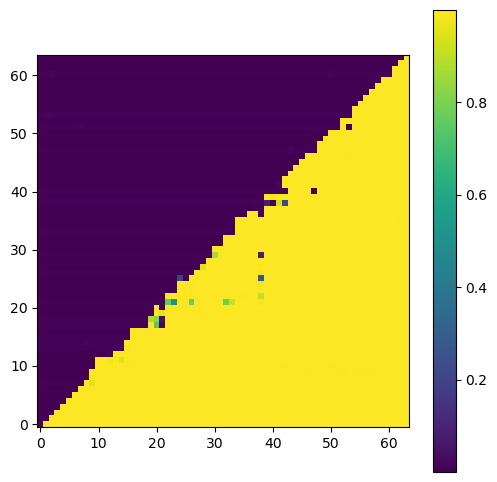

In [37]:
# plot final model outputs for each pair of objects 
order_relation_matrix = np.zeros(shape=(num_objects, num_objects))

for i in range(num_objects):
    for j in range(num_objects):
        inputs = tf.one_hot(np.array([[i,j]]), num_objects)
        order_relation_matrix[i,j] = model(inputs)[0].numpy()

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(order_relation_matrix, cmap='gray')
ax.invert_yaxis()
fig.colorbar(im, ax=ax);

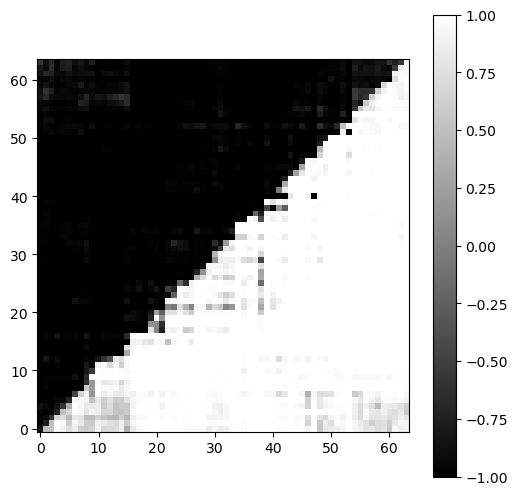

In [38]:
# plot relational cross-attention attention score when input is a pair of objects

order_relation_matrix = np.zeros(shape=(num_objects, num_objects))

for i in range(num_objects):
    for j in range(num_objects):
        object_pair = tf.one_hot(np.array([[i, j]]), num_objects)
        attention_output, attention_scores = relational_crossattention(query=object_pair, key=object_pair, 
            value=object_pair, return_attention_scores=True)
        attention_score = np.squeeze(attention_scores)[0][1]
        order_relation_matrix[i,j] = attention_score

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(order_relation_matrix, cmap='gray')
ax.invert_yaxis()
fig.colorbar(im, ax=ax);

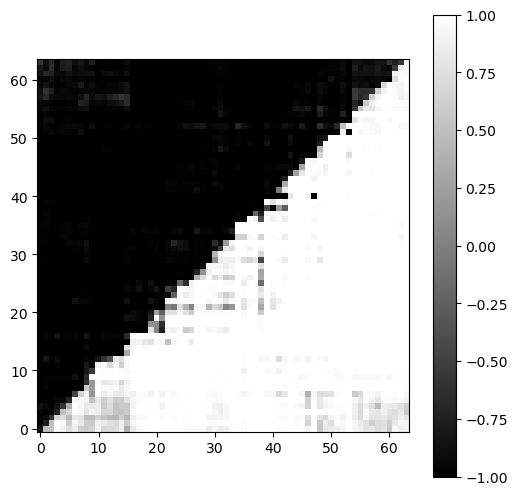

In [39]:
# plot relational cross-attention attention score when input is a triplet of objects
# here, we fix the first object and vary second two, then we plot the relations of the other two objects
# with linear/sigmoid/tanh activation, adding objects does not affect the relations between existing objcets
# i.e.: this is exactly the same plot as the above (unlike with softmax activation)

order_relation_matrix = np.zeros(shape=(num_objects, num_objects))

for i in range(num_objects):
    for j in range(num_objects):
        object_pair = tf.one_hot(np.array([[32, i,j]]), num_objects)
        # object_pair = np.array([[objects[0][16,:], objects[0][i,:], objects[0][j, :]]])
        attention_output, attention_scores = relational_crossattention(query=object_pair, key=object_pair, 
            value=object_pair, return_attention_scores=True)
        attention_score = np.squeeze(attention_scores)[1][2]
        order_relation_matrix[i,j] = attention_score

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(order_relation_matrix, cmap='gray')
ax.invert_yaxis()
fig.colorbar(im, ax=ax);

In [40]:
objects = tf.expand_dims(tf.one_hot(np.arange(num_objects), num_objects), axis=0)

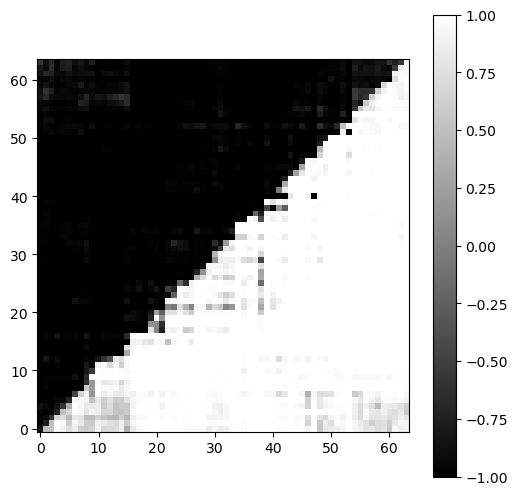

In [41]:
# now, compute the relations between all pairs directly 
# by passing all the objects to the relational cross-attention simultaneously
# the results are now interpretable, unlike with softmax!
# again, exact same plot as above; relation depends only on pair

attention_output, attention_scores = relational_crossattention(query=objects, key=objects, value=objects, return_attention_scores=True)
attention_scores = np.squeeze(attention_scores)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(attention_scores, cmap='gray')
ax.invert_yaxis()
fig.colorbar(im, ax=ax);